In [ ]:
%pylab inline 

In [ ]:
gauss = lambda edges,sig,n: exp(-edges**2/2/sig**2)/(2*pi)**.5/sig*n*(edges[1]-edges[0])

#### Can't we take the real part of the field? Isn't the sum of two Gaussians a Gaussian?

1.2471506942808959 1.9797338820933175


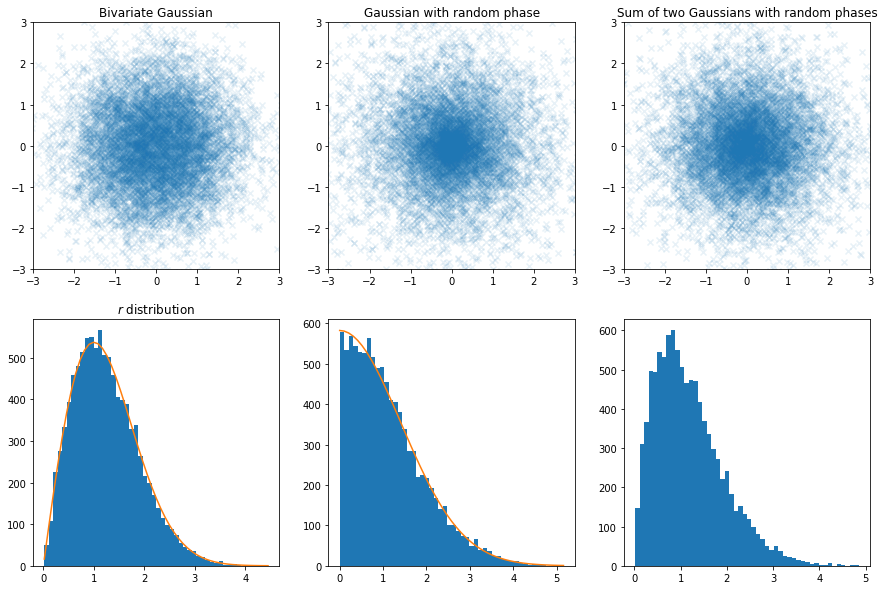

In [3]:
figure(figsize=(15,10))
n=10000
subplot(231)
a = randn(2,n)
scatter(a[0],a[1],alpha=0.1,marker="x")
xlim(-3,3)
ylim(-3,3)
title("Bivariate Gaussian")
subplot(234)
b=sqrt(a[0]**2+a[1]**2)
c,e,p=hist(b,bins=50)
print(mean(b),mean(b**2))
title("$r$ distribution")
plot(e,gauss(e,1,n)*e*(2*pi)**.5)
subplot(232)
a=randn(n)*exp(2j*pi*rand(n))*2**.5
scatter(real(a),imag(a),alpha=0.1,marker="x")
xlim(-3,3)
ylim(-3,3)
title("Gaussian with random phase")
subplot(235)
c,e,p=hist(abs(a),bins=50)
plot(e,gauss(e,2**.5,n*2))
subplot(233)
title("Sum of two Gaussians with random phases")
a=randn(n)*exp(2j*pi*rand(n))+randn(n)*exp(2j*pi*rand(n))
scatter(real(a),imag(a),alpha=0.1,marker="x")
xlim(-3,3)
ylim(-3,3)
subplot(236)
c,e,p=hist(abs(a),bins=50)

In [4]:
def field_from_spectrum(ps,boxsize=128,n=1):
    f=randn(n,boxsize,boxsize)*exp(2j*pi*rand(n,boxsize,boxsize))
    for i in range(boxsize//2+1):
        for j in range(boxsize):
            f[:,i,j]=f[:,i,j]*ps((i**2+min(j,boxsize-j)**2)**.5)**.5
    f[:,0,0]=0
    if not boxsize%2:
        f[:,0,boxsize//2]=abs(f[:,0,boxsize//2])*(randint(2,size=n)*2-1)
        f[:,boxsize//2,0]=abs(f[:,boxsize//2,0])*(randint(2,size=n)*2-1)
        f[:,boxsize//2,boxsize//2]=abs(f[:,boxsize//2,boxsize//2])*(randint(2,size=n)*2-1)
        for i in range(boxsize//2+1,boxsize):
            f[:,boxsize//2,i]=conj(f[:,boxsize//2,boxsize-i])
    for j in range(boxsize//2+1,boxsize):
        f[:,0,j]=conj(f[:,0,boxsize-j])
        f[:,j,0]=conj(f[:,boxsize-j,0])
        for i in range(1,boxsize):
            f[:,j,i]=conj(f[:,boxsize-j,boxsize-i])
    return real(fft.fft2(f))

BTW, I set $P(0)=0$ in this notebook (so mean of field is 0). I tested it on the machines trained without this and it made no difference.

1749.2140409001108


Text(0.5, 1.0, 'true $\\Phi(x)$ distribution')

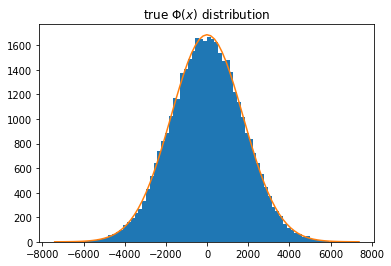

In [5]:
bs=200
x=field_from_spectrum(lambda x: x,boxsize=bs).flatten()
sig=std(x)
c,edges,p=hist(x,bins=80)
plot(edges,gauss(edges,sig,bs**2))
print(sig)
title("true $\Phi(x)$ distribution")

In [6]:
def wonky_field_from_spectrum(ps,boxsize=128,n=1):
    f=randn(n,boxsize,boxsize)*exp(2j*pi*rand(n,boxsize,boxsize))
    for i in range(boxsize):
        for j in range(boxsize):
            f[:,i,j]=f[:,i,j]*ps((i**2+min(j,boxsize-j)**2)**.5)**.5
    return real(fft.fft2(f))*sqrt(2)

2174.1694357655624


Text(0.5, 1.0, 'wonky $\\Phi(x)$ distribution')

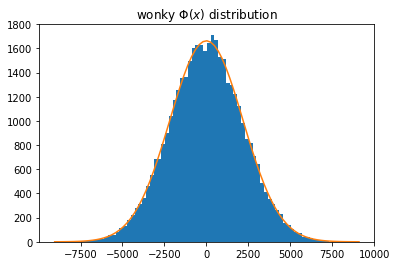

In [7]:
bs=200
x=wonky_field_from_spectrum(lambda x: x,boxsize=bs).flatten()
sig=std(x)
c,edges,p=hist(x,bins=80)
plot(edges,gauss(edges,sig,bs**2))
print(sig)
title("wonky $\Phi(x)$ distribution")

In [8]:
from scipy.stats import binned_statistic

def power_spectrum(x):
    size=x.shape[-1]
    kx,ky=arange(size),arange(size)
    kx,ky=minimum(kx,size-kx),minimum(kx,size-kx)
    kx,ky=meshgrid(kx,ky)
    k=sqrt(kx**2+ky**2).flatten()
    p=(abs(fft.ifft2(x))**2).flatten()
    avg,edges,f= binned_statistic(k,p)
    err,edges,f= binned_statistic(k,p**2)
    count,edges,f=binned_statistic(k,p,statistic="count")
    return (edges[:-1]+edges[1:])/2,avg,sqrt((err-avg**2)/count),count

/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Text(0.5, 1.0, 'power spectrum')

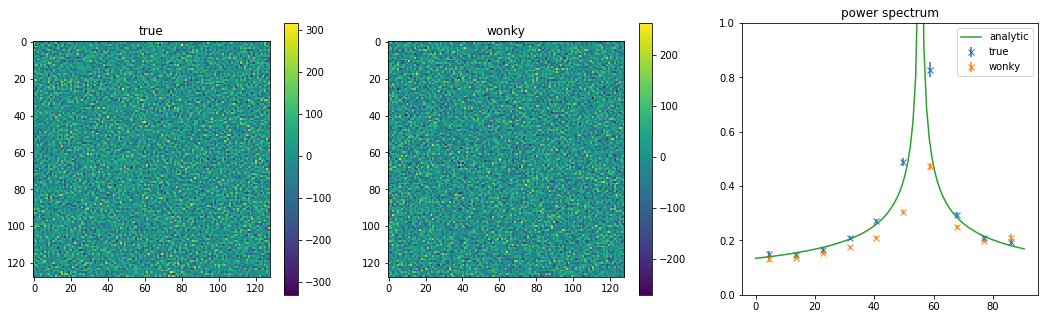

In [9]:
figure(figsize=(18,5))
fn = lambda x: abs(x-55.5)**-.5
x=field_from_spectrum(fn)[0]
y=wonky_field_from_spectrum(fn)[0]
subplot(131)
imshow(x)
colorbar()
title("true")
subplot(132)
imshow(y)
colorbar()
title("wonky")
subplot(133)
xe,xm,xerr,xc=power_spectrum(x)
ye,ym,yerr,yc=power_spectrum(y)
errorbar(xe,xm,yerr=xerr,marker="x",ls="",label="true")
errorbar(ye,ym,yerr=yerr,marker="x",ls="",label="wonky")
k=linspace(0,64*2**.5,100)
plot(k,fn(k),label="analytic")
ylim(0,1)
legend()
title("power spectrum")

In [10]:
def get_flt_k_f(x):
    size=x.shape[-1]
    kx,ky=arange(size),arange(size)
    kx,ky=minimum(kx,size-kx),minimum(kx,size-kx)
    kx,ky=meshgrid(kx,ky)
    k=sqrt(kx**2+ky**2).flatten()
    fk=fft.ifft2(x).flatten()
    return k,fk

def norm_10_bins(x):
    size=x.shape[-1]
    k,fk=get_flt_k_f(x)
    p=abs(fk)**2
    avg,edges,binnum= binned_statistic(k,p)
    #print(avg,edges,k[:10],binnum[:10])
    for i in range(size**2):
        fk[i]=fk[i]/avg[binnum[i]-1]**.5
    fk=fk.reshape((size,size))
    return real(fft.fft2(fk))

def norm_func(x,fn):
    size=x.shape[-1]
    k,fk=get_flt_k_f(x)
    p=array([fn(kk) for kk in k])
    fk=fk/p**.5
    return real(fft.fft2(fk.reshape((size,size))))

def bin_by_count(k,n):
    ss={}
    for i in range(len(k)):
        if k[i] in ss.keys():
            ss[k[i]].append(i)
        else:
            ss[k[i]]=[i]
    ks=sorted(ss)
    lens=[len(ss[kk]) for kk in ks]
    indices=[]
    currind=[]
    edges=[ks[0]]
    for kk in ks:
        currind = currind + ss[kk]
        if len(currind) >= n:
            edges.append(kk)
            indices.append(currind)
            currind=[]
    indices[-1]=indices[-1]+currind
    edges[-1]=ks[-1]
    return indices,edges

def dynamic_ps(x,count=20):
    size=x.shape[-1]
    k,fk=get_flt_k_f(x)
    p=abs(fk)**2
    indices,edges=bin_by_count(k,count)
    binned_k=[[k[ices] for ices in ind] for ind in indices]
    binned_p=[[p[ices] for ices in ind] for ind in indices]
    mean_p=[mean(pp) for pp in binned_p]
    std_p=[std(pp)/len(pp)**.5 for pp in binned_p]
    mean_k=[mean(kk) for kk in binned_k]
    count = [len(pp) for pp in indices]
    return mean_k,mean_p,std_p,count

def norm_binning_by_count(x,count=20):
    size=x.shape[-1]
    k,fk=get_flt_k_f(x)
    p=abs(fk)**2
    indices,edges=bin_by_count(k,count)
    binned_k=[[k[ices] for ices in ind] for ind in indices]
    binned_p=[[p[ices] for ices in ind] for ind in indices]
    mean_p=[mean(pp) for pp in binned_p]
    for i,ind in enumerate(indices):
        for ices in ind:
            fk[ices]=fk[ices]/mean_p[i]**.5
    fk[0]=0
    return real(fft.fft2(fk.reshape((size,size))))

def renorm_count(x,fn,count=20):
    size=x.shape[-1]
    k,fk=get_flt_k_f(x)
    p=abs(fk)**2
    indices,edges=bin_by_count(k,count)
    binned_k=[[k[ices] for ices in ind] for ind in indices]
    binned_p=[[p[ices] for ices in ind] for ind in indices]
    mean_p=[mean(pp) for pp in binned_p]
    std_p=[std(pp)/len(pp)**.5 for pp in binned_p]
    for i,ind in enumerate(indices):
        for ices in ind:
            fk[ices]=fk[ices]*(fn(k[ices])/mean_p[i])**.5
    fk[0]=0
    return real(fft.fft2(fk.reshape((size,size))))

(0, 1)

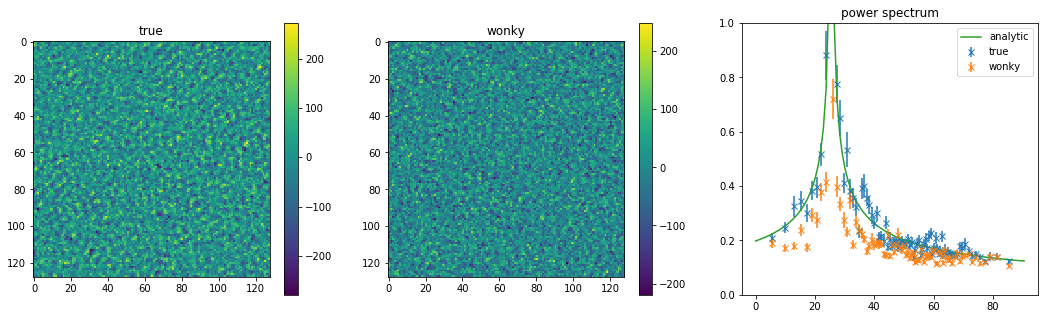

In [11]:
figure(figsize=(18,5))
fn = lambda x: abs(x-25.5)**-.5
x=field_from_spectrum(fn)[0]
y=wonky_field_from_spectrum(fn)[0]
subplot(131)
title("true")
imshow(x)
colorbar()
subplot(132)
title("wonky")
imshow(y)
colorbar()
subplot(133)
xe,xm,xerr,xc=dynamic_ps(x,count=200)
ye,ym,yerr,yc=dynamic_ps(y,count=200)
errorbar(xe,xm,yerr=xerr,marker="x",ls="",label="true")
errorbar(ye,ym,yerr=yerr,marker="x",ls="",label="wonky")
k=linspace(0,64*2**.5,100)
plot(k,fn(k),label="analytic")
legend()
title("power spectrum")
ylim(0,1)

### How well does normalising work for different kinds of power spectra?

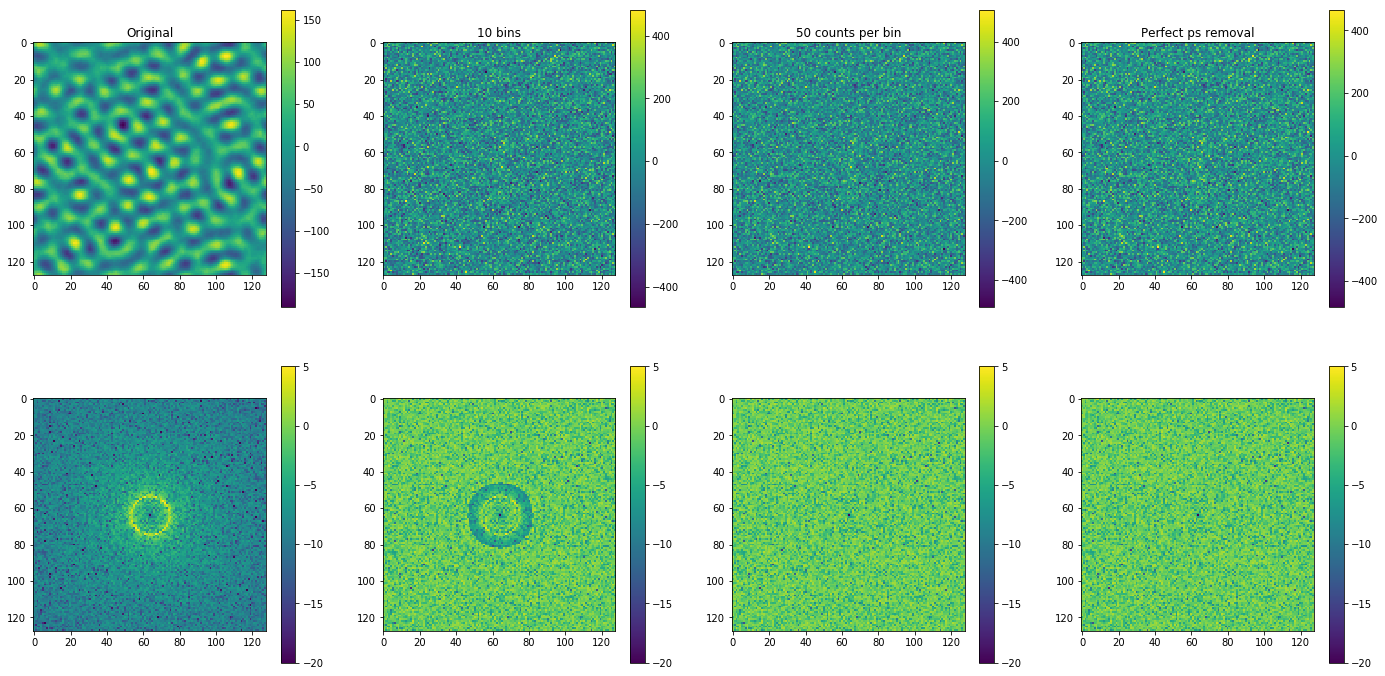

In [12]:
figure(figsize=(24,12))
fn = lambda x: abs(x-10.5)**-2
count=50
subplot(241)
title("Original")
x=field_from_spectrum(fn,boxsize=128)[0]
imshow(x)
colorbar()
subplot(242)
title("10 bins")
imshow(norm_10_bins(x))
colorbar()
subplot(243)
title(str(count)+" counts per bin")
imshow(norm_binning_by_count(x,count=count))
colorbar()
subplot(244)
title("Perfect ps removal")
imshow(norm_func(x,fn))
colorbar()
subplot(245)
imshow(fft.fftshift(log(abs(fft.ifft2(x))**2)),vmin=-20,vmax=5)
colorbar()
subplot(246)
imshow(fft.fftshift(log(abs(fft.ifft2(norm_10_bins(x)))**2)),vmin=-20,vmax=5)
colorbar()
subplot(247)
imshow(fft.fftshift(log(abs(fft.ifft2(norm_binning_by_count(x,count=count)))**2)),vmin=-20,vmax=5)
colorbar()
subplot(248)
imshow(fft.fftshift(log(abs(fft.ifft2(norm_func(x,fn)))**2)),vmin=-20,vmax=5)
colorbar()

### Adding nonlinearity
$$\Phi(x)=\Phi_L(x)+f_{NL}\left(\Phi(x)^2-\left\langle\!\Phi(x)^2\!\right\rangle\right)$$
$$\left\langle\!\Phi(x)^2\!\right\rangle=\int \frac{d^Dk}{(2\pi)^D}P(|k|)=\sum_k P(|k|)$$
$$\left\langle\!\Phi(k)\Phi^*(k')\!\right\rangle=(2\pi)^D\delta^{(D)}(k-k')\left(P(|k|)+f_{NL}^2\int d^Dp\:P(|p|)P(|k+p|)\right)=\delta_{k,k'}\left(P(|k|)+f_{NL}^2\sum_p P(|p|)P(|k+p|)\right)$$

Can we estimate $\left\langle\!\Phi(x)^2\!\right\rangle$ by averaging over image?

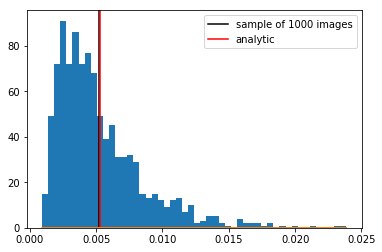

In [13]:
n=1000
size=32
fn = lambda x: abs(x-25.01)**-7
x=field_from_spectrum(fn,size,n)
c,e,p=hist(mean(x**2,axis=(-1,-2)).flatten(),bins=50)
axvline(x=mean(x**2),c="k",label="sample of "+str(n)+" images")
kx,ky=arange(size),arange(size)
kx,ky=minimum(kx,size-kx),minimum(kx,size-kx)
kx,ky=meshgrid(kx,ky)
k=sqrt(kx**2+ky**2).flatten()
anal=sum(fn(k))-fn(0)
axvline(x=anal,c="r",label="analytic")
legend()
plot(e,exp(-e/2/anal)*e/(2*pi*anal)**.5*n*(e[1]-e[0]))

Better to use analytic

In [14]:
def add_nl(x,fNL):
    return x + fNL*(x**2-mean(x**2))

def add_nl_proper(x,fNL,fn):
    k,f=get_flt_k_f(x)
    mx = sum(fn(k))-fn(0)
    return x + fNL*(x**2-mx)

Text(0.5, 1.0, 'Power spectrum')

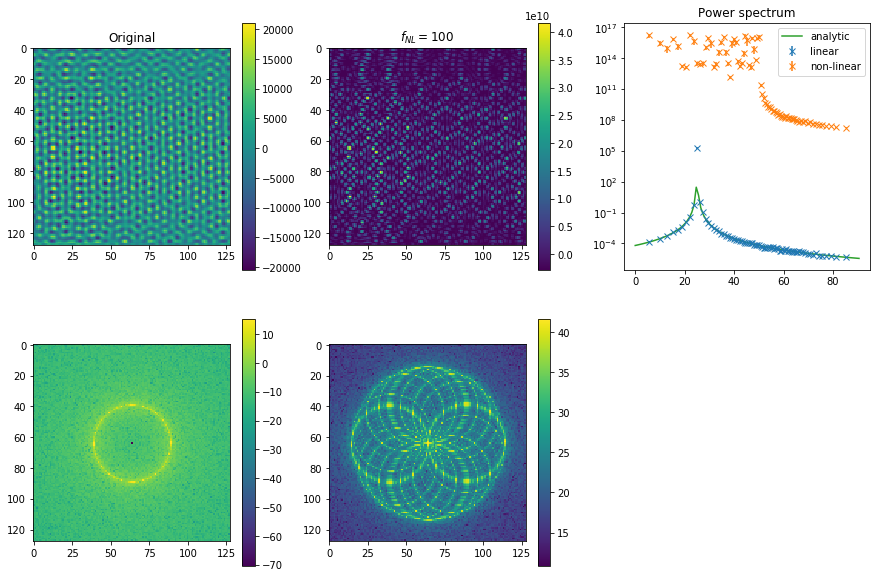

In [15]:
figure(figsize=(15,10))
fn = lambda x: abs(x-25.01)**-3
fNL=100
count=50
x=field_from_spectrum(fn)[0]
subplot(231)
imshow(x)
colorbar()
title("Original")
subplot(234)
imshow(fft.fftshift(log(abs(fft.ifft2(x))**2)))
colorbar()
subplot(232)
x_nl=add_nl_proper(x,fNL,fn)
title("$f_{NL}="+str(fNL)+"$")
imshow(x_nl)
colorbar()
subplot(235)
imshow(fft.fftshift(log(abs(fft.ifft2(x_nl))**2)))
colorbar()
subplot(233)
xe,xm,xerr,xc=dynamic_ps(x,count=200)
ye,ym,yerr,yc=dynamic_ps(x_nl,count=200)
errorbar(xe,xm,yerr=xerr,marker="x",ls="",label="linear")
errorbar(ye,ym,yerr=yerr,marker="x",ls="",label="non-linear")
x=linspace(0,64*2**.5,100)
semilogy(x,fn(x),label="analytic")
legend()
title("Power spectrum")

Squared nonlinearities in real space = convolution with itself in Fourier space. Need to re-normalise PS.

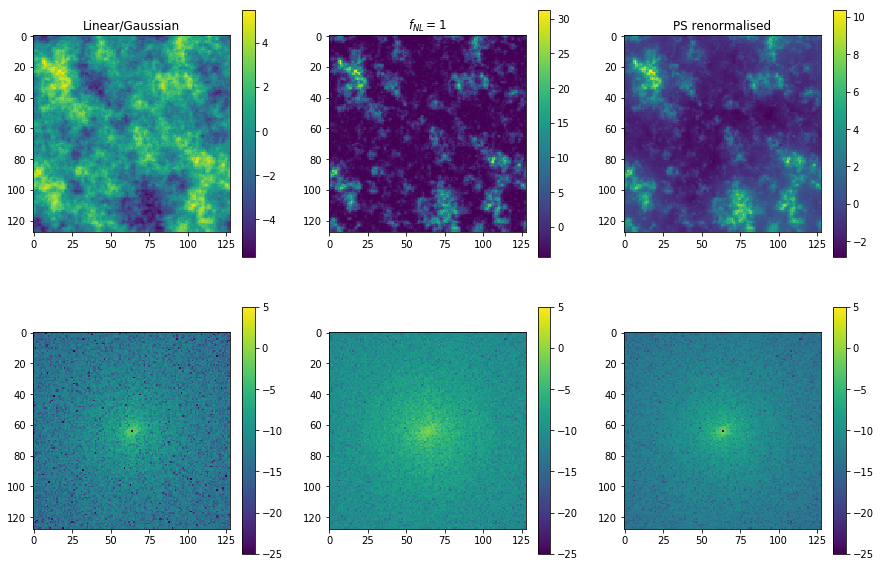

In [16]:
figure(figsize=(15,10))
fn = lambda x: abs(x+0.5)**-3
fNL=1
count=50
x=field_from_spectrum(fn)[0]
subplot(231)
imshow(x)
colorbar()
title("Linear/Gaussian")
subplot(234)
imshow(fft.fftshift(log(abs(fft.ifft2(x))**2)),vmin=-25,vmax=5)
colorbar()
subplot(232)
x_nl=add_nl_proper(x,fNL,fn)
title("$f_{NL}="+str(fNL)+"$")
imshow(x_nl)
colorbar()
subplot(235)
imshow(fft.fftshift(log(abs(fft.ifft2(x_nl))**2)),vmin=-25,vmax=5)
colorbar()
subplot(233)
title("PS renormalised")
rx=renorm_count(x_nl,fn)
imshow(rx)
colorbar()
subplot(236)
imshow(fft.fftshift(log(abs(fft.ifft2(rx))**2)),vmin=-25,vmax=5)
colorbar()

Text(0.5, 1.0, 'Power spectrum')

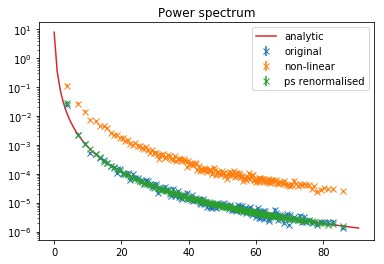

In [17]:
k=linspace(0,64*2**.5,100)
count=100
k1,x1,e1,c1=dynamic_ps(x,count)
errorbar(k1,x1,yerr=e1,label="original",marker="x",ls="")
k2,x2,e2,c2=dynamic_ps(x_nl,count)
errorbar(k2,x2,yerr=e2,label="non-linear",marker="x",ls="")
k3,x3,e3,c3=dynamic_ps(rx,count)
errorbar(k3,x3,yerr=e3,label="ps renormalised",marker="x",ls="")
semilogy(k,fn(k),label="analytic")
legend()
title("Power spectrum")

### Does a machine trained to find PS of Guassian field still work with non-linearities?

In [18]:
import tensorflow as tf

class PSEp_2d(tf.estimator.Estimator):

    def __init__(self,
               feature_columns,
               label_columns,
               optimizer=tf.train.AdamOptimizer,
               activation_fn=tf.nn.relu,
               normalizer_fn=tf.contrib.layers.batch_norm,
               dropout=None,
               model_dir=None,
               config=None):
        """Initializes a PSE_1d_v1 instance.
        """

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,32,32,1)), 4, 3, activation=tf.nn.leaky_relu)
            pool = tf.layers.max_pooling2d(conv, 3,2)
            conv = tf.layers.conv2d(pool, 16, 3, activation=tf.nn.leaky_relu)
            pool = tf.layers.max_pooling2d(conv, 3,2)
            conv = tf.layers.conv2d(pool, 64, 3, activation=tf.nn.leaky_relu)
            pool = tf.reshape(tf.layers.max_pooling2d(conv, 3,2),(-1,64))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(pool,rate=0.2,training=training),32,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),16,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),8,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),4,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),2,activation_fn=tf.nn.tanh)
            predictions = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),1,activation_fn=tf.nn.tanh)

            train_op = None
            eval_metric_ops = None
            
            # Define optimizer
            if mode == tf.estimator.ModeKeys.PREDICT:
                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
            
            loss=tf.losses.mean_squared_error(predictions,labels)
            
            if training:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.0002).minimize(loss=loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "loss": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)

In [19]:
# box size
size=32

# Define input function for estimator
batch_size = 1024
fNL=1

nsims_test = 1000

# Parametrise ps
def pps(par):
    return lambda x: (x+.5)**-par

p_test = 5*rand(nsims_test,1)

x_test = array([renorm_count(add_nl_proper(field_from_spectrum(pps(p[0]),boxsize=size)[0],fNL,pps(p[0])),pps(p[0])) for p in p_test])

normalised_p_test = (p_test-2.5)/2.5

def _testing_input_fn():
    """Serving input fn for testing data"""
    dataset = tf.data.Dataset.from_tensor_slices((x_test.astype('float32'), normalised_p_test.astype('float32')))
    dataset = dataset.batch(batch_size)
    return dataset

In [20]:
model = PSEp_2d(['x'], ['p'], model_dir='models/pse2_model2')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/pse2_model2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aaadb7fe4a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/pse2_model2/model.ckpt-30040
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.09693194691289671 0.01081553024259375


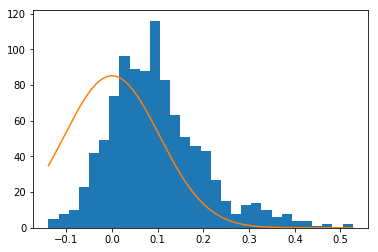

In [21]:
pred = model.predict(_testing_input_fn)
cnn_pred=zeros(nsims_test)
for i in range(nsims_test):
    cnn_pred[i]=(next(pred)[0]+1)*2.5
sig=std(cnn_pred-p_test[:,0])
count,edges,patches=hist((cnn_pred-p_test[:,0]).flatten(),bins=30)
x=linspace(edges[0],edges[-1],1000)
plot(x,nsims_test*exp(-x**2/sig**2/2)/(2*pi)**.5/sig*(edges[1]-edges[0]))
print(mean(cnn_pred-p_test[:,0]),sig**2)

Text(0, 0.5, 'CNN prediction')

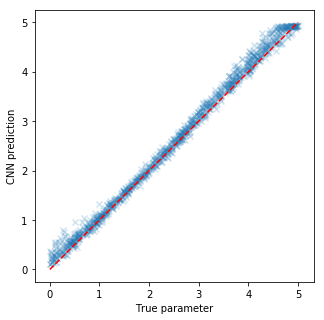

In [22]:
figure(figsize=(5,5))
plot(linspace(0,5,100),linspace(0,5,100),c="r",ls="--")
scatter(p_test,cnn_pred,alpha=0.2,marker="x")
xlabel("True parameter")
ylabel("CNN prediction")

### It works, but is biased slightly up. Does this bias change with $f_{NL}$?

In [23]:
fnl_len=21
fnls=logspace(-5,2,fnl_len)
cnn_pred=zeros((nsims_test,fnl_len))
for i in range(fnl_len):
    print(i)
    x_test = array([renorm_count(add_nl_proper(field_from_spectrum(pps(p[0]),boxsize=size)[0],fnls[i],pps(p[0])),pps(p[0])) for p in p_test])
    pred = model.predict(_testing_input_fn)
    for j in range(nsims_test):
        cnn_pred[j,i]=(next(pred)[0]+1)*2.5

0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/pse2_model2/model.ckpt-30040
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
1
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/pse2_model2/model.ckpt-30040
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
2
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/pse2_model2/model.ckpt-30040
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
3
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/pse2_model2/model.ck

Text(0, 0.5, 'CNN prediction')

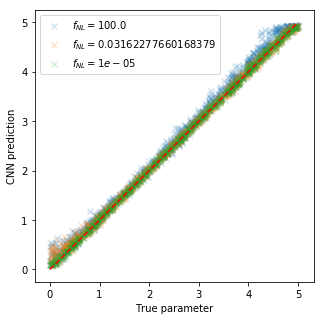

In [24]:
figure(figsize=(5,5))
for i in [-1,fnl_len//2,0]:
    scatter(p_test,cnn_pred[:,i],label="$f_{NL}="+str(fnls[i])+"$",marker="x",alpha=0.2)
legend()
plot(linspace(0,5,100),linspace(0,5,100),ls="--",c="r")
xlabel("True parameter")
ylabel("CNN prediction")

Text(0.5, 0, '$f_{NL}$')

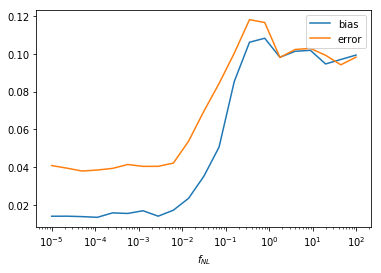

In [25]:
bias=mean(cnn_pred-p_test,axis=0)
err=std(cnn_pred-p_test,axis=0)
semilogx(fnls,bias,label="bias")
semilogx(fnls,err,label="error")
legend()
xlabel("$f_{NL}$")

#### Bias and error both have a sudden jump as nonlinearities increase. Why?

Now let's try the same thing with convergence maps

In [26]:
from nbodykit.lab import *
#from nbodykit.source import BigFileMesh
from nbodykit.cosmology import Planck15, LinearPower

path_ini = '/global/cscratch1/sd/avirukt/'

boxsize = 512
pixnum  = 512
steps   = 10

name = "testing"
path_ini = path_ini+'%s/%s-18'%(name,name)
phicat = BigFileCatalog(path_ini+'/data_catalog.bigfile')
ax1 = 1
ax2 = 0

tags=['gamma1','gamma2','kappa']

fs  = {}
n   = {}

for ii, tag in enumerate(tags):
    phicat.compute(phicat['LFs'])
    pm=BigFileMesh(path_ini, dataset='s').paint(mode='real').pm
    LFsum = pm.paint(phicat['Position'], mass=phicat['LFs'][:,ii])
    n[tag] = pm.paint(phicat['Position'], mass=phicat['noise'][:,ii])
    Nsum = pm.paint(phicat['Position'])
    Nsum[Nsum==0.]=1
    fs[tag]=LFsum / Nsum

k=fs['kappa'].preview(axes=(ax1,ax2))

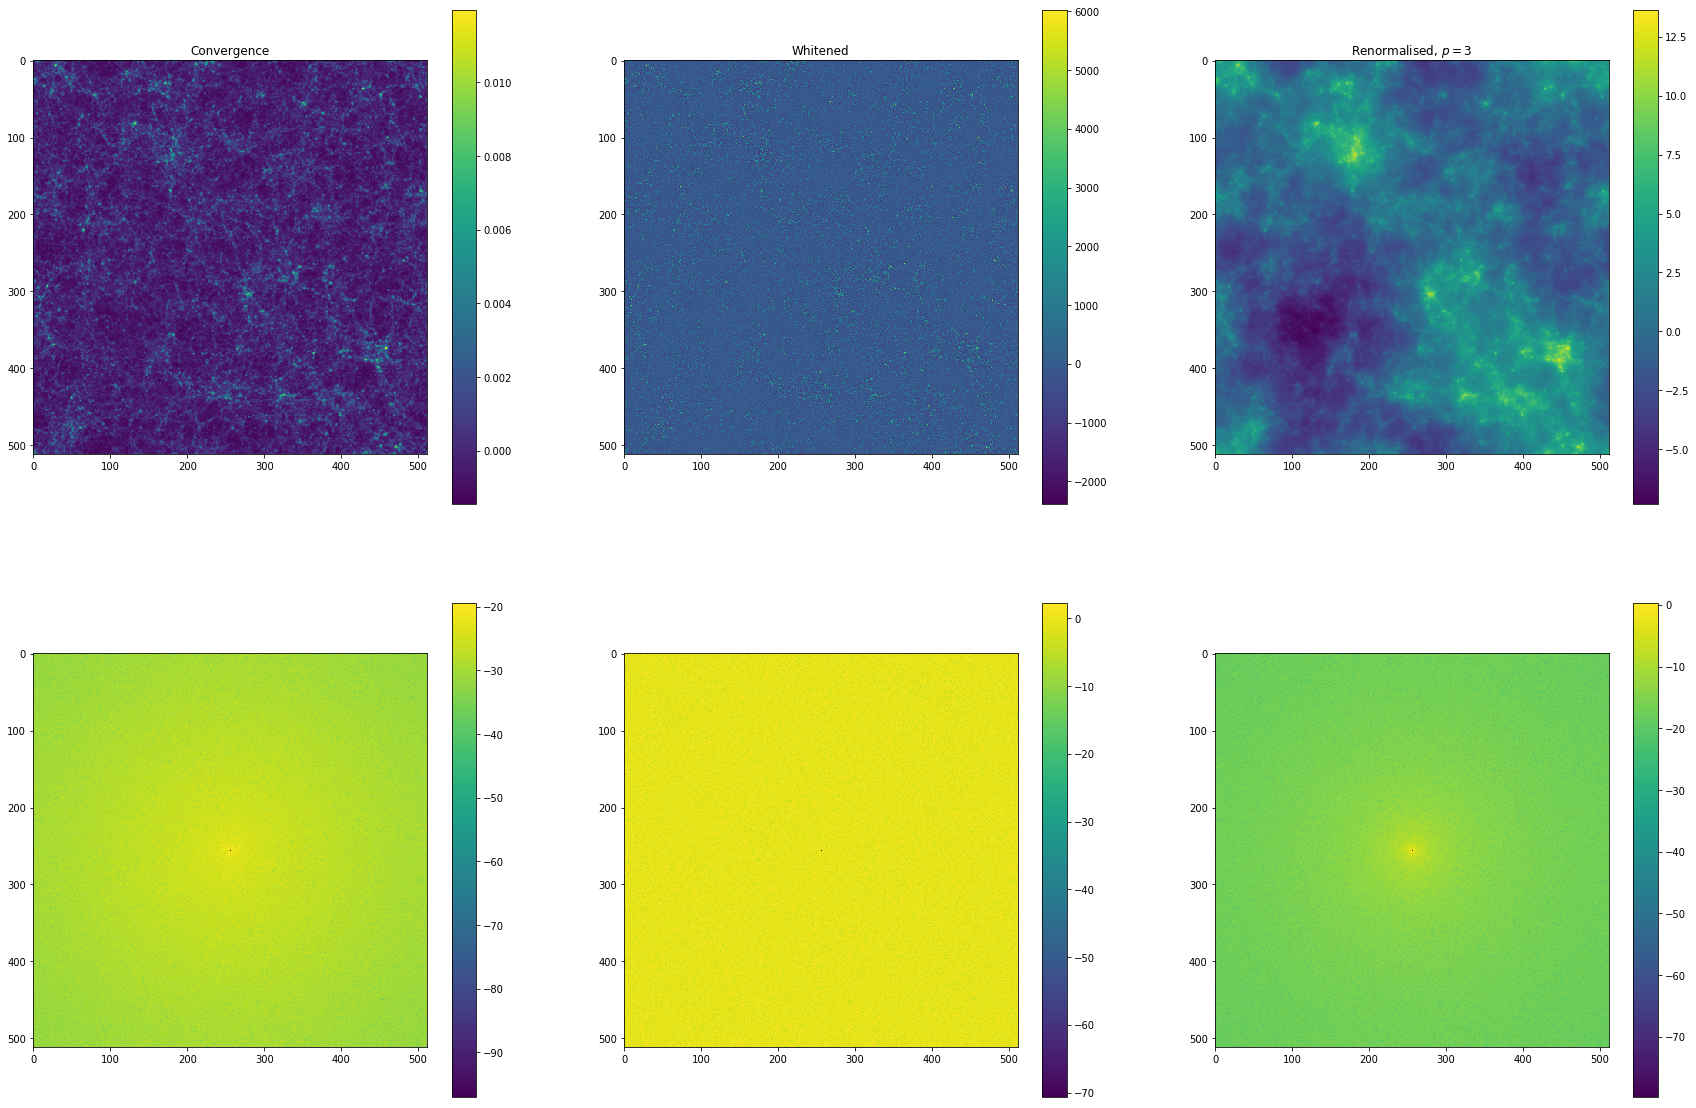

In [27]:
figure(figsize=(30,20))
subplot(231)
imshow(k)
colorbar()
title("Convergence")
subplot(234)
imshow(fft.fftshift(log(abs(fft.ifft2(k))**2)))
colorbar()
subplot(232)
title("Whitened")
kw=renorm_count(k,lambda x: 1)
imshow(kw)
colorbar()
subplot(235)
imshow(fft.fftshift(log(abs(fft.ifft2(kw))**2)))
colorbar()
subplot(233)
p=3
kr=renorm_count(k,lambda x: (x+0.1)**-p)
imshow(kr)
colorbar()
title("Renormalised, $p="+str(p)+"$")
subplot(236)
imshow(fft.fftshift(log(abs(fft.ifft2(kr))**2)))
colorbar()

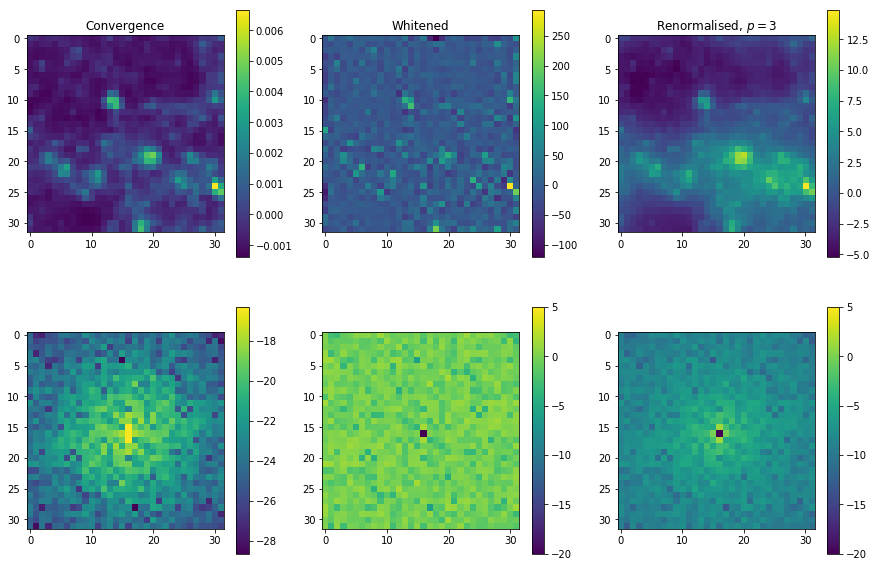

In [28]:
kp = zeros((256,32,32))
for i in range(16):
    for j in range(16):
        kp[16*i+j]=k[32*i:32*(i+1),32*j:32*(j+1)]
i=randint(256)
figure(figsize=(15,10))
subplot(231)
imshow(kp[i])
colorbar()
title("Convergence")
subplot(234)
imshow(fft.fftshift(log(abs(fft.ifft2(kp[i]))**2)))
colorbar()
subplot(232)
title("Whitened")
kw=renorm_count(kp[i],lambda x: 1)
imshow(kw)
colorbar()
subplot(235)
imshow(fft.fftshift(log(abs(fft.ifft2(kw))**2)),vmin=-20,vmax=5)
colorbar()
subplot(233)
p=3
kr=renorm_count(kp[i],lambda x: (x+0.1)**-p)
imshow(kr)
colorbar()
title("Renormalised, $p="+str(p)+"$")
subplot(236)
imshow(fft.fftshift(log(abs(fft.ifft2(kr))**2)),vmin=-20,vmax=5)
colorbar()

In [29]:
pt64=5*rand(256,1)
pt64n=(pt64-2.5)/2.5
xt64 = array([renorm_count(kp[i],pps(pt64[i,0])) for i in range(256)])
def tt64():
    """Serving input fn for testing data"""
    dataset = tf.data.Dataset.from_tensor_slices((xt64.astype('float32'), pt64n.astype('float32')))
    dataset = dataset.batch(batch_size)
    return dataset

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/pse2_model2/model.ckpt-30040
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.1393542025406021 0.09757482285043585


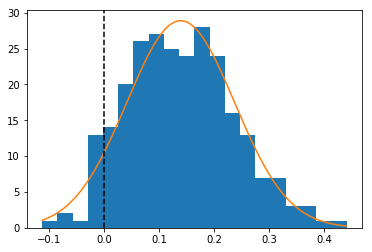

In [30]:
pred = model.predict(tt64)
cnn_pred=zeros(256)
for i in range(256):
    cnn_pred[i]=(next(pred)[0]+1)*2.5
mu,sig=mean(cnn_pred-pt64[:,0]),std(cnn_pred-pt64[:,0])
count,edges,patches=hist((cnn_pred-pt64[:,0]).flatten(),bins=20)
x=linspace(edges[0],edges[-1],1000)
plot(x,256*exp(-(x-mu)**2/sig**2/2)/(2*pi)**.5/sig*(edges[1]-edges[0]))
print(mu,sig)
axvline(x=0,c="k",ls="--")

Text(0, 0.5, 'CNN prediction')

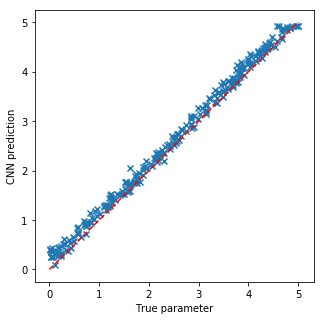

In [31]:
figure(figsize=(5,5))
plot(linspace(0,5,100),linspace(0,5,100),c="r",ls="--")
scatter(pt64[:,0],cnn_pred,marker="x")
xlabel("True parameter")
ylabel("CNN prediction")

This is also biased up.

### Is the CNN better at learning large or small scale info?
Let's train on PS with 4 independent bands.

In [32]:
import tensorflow as tf

class PSEp_2d_32_4b(tf.estimator.Estimator):

    def __init__(self,
               feature_columns,
               label_columns,
               optimizer=tf.train.AdamOptimizer,
               activation_fn=tf.nn.relu,
               normalizer_fn=tf.contrib.layers.batch_norm,
               dropout=None,
               model_dir=None,
               config=None):

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,32,32,1)), 4, 3, activation=tf.nn.leaky_relu)
            pool = tf.layers.max_pooling2d(conv, 3,2)
            conv = tf.layers.conv2d(pool, 16, 3, activation=tf.nn.leaky_relu)
            pool = tf.layers.max_pooling2d(conv, 3,2)
            conv = tf.layers.conv2d(pool, 64, 3, activation=tf.nn.leaky_relu)
            pool = tf.reshape(tf.layers.max_pooling2d(conv, 3,2),(-1,64))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(pool,rate=0.2,training=training),32,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),16,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),8,activation_fn=tf.nn.tanh)
            predictions = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),4,activation_fn=tf.nn.tanh)

            train_op = None
            eval_metric_ops = None
            
            # Define optimizer
            if mode == tf.estimator.ModeKeys.PREDICT:
                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
            
            loss=tf.losses.mean_squared_error(predictions,labels)
            
            if training:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.0002).minimize(loss=loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "loss": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)

In [ ]:
# box size
size=32

# Define input function for estimator
batch_size = 128

# Number of training and testing simulations
nsims_train = 10000
nsims_test = 1000

#number of bands
nbands = 4

# Parametrise ps
def pps(par):
    dk=(size/2+1)*2**.5/nbands
    return lambda k: par[int(k/dk)]

# sample bandpowers uniformly from [0,1]
p_train = rand(nsims_train,nbands)
p_test = rand(nsims_test,nbands)

x_train = array([field_from_spectrum(pps(p),boxsize=size)[0] for p in p_train])
x_test = array([field_from_spectrum(pps(p),boxsize=size)[0] for p in p_test])

normalised_p_train = (p_train-.5)*2
normalised_p_test = (p_test-.5)*2

def _training_fn():
    """Serving input fn for training data"""
    dataset = tf.data.Dataset.from_tensor_slices((x_train.astype('float32'), normalised_p_train.astype('float32')))
    dataset = dataset.repeat().shuffle(1000).batch(batch_size)
    return dataset

def _testing_fn():
    """Serving input fn for testing data"""
    dataset = tf.data.Dataset.from_tensor_slices((x_test.astype('float32'), normalised_p_test.astype('float32')))
    dataset = dataset.batch(batch_size)
    return dataset

In [ ]:
i=randint(nsims_train)
k1,x1,e1,c1=dynamic_ps(x_train[i],20)
errorbar(k1,x1,yerr=e1,marker="x",ls="")
for j in range(nbands):
    axvline(x=j*(size/2+1)*2**.5/nbands,c="k",ls="--")
    plot(array([j,j+1])*(size/2+1)*2**.5/nbands,repeat(p_train[i,j],2),c="r")
axvline(x=(size/2+1)*2**.5,c="k",ls="--")

In [35]:
def equal_spacing_ps(x,dk):
    size=x.shape[-1]
    k,f = get_flt_k_f(x)
    p=abs(f)**2
    l=int(ceil((size/2+1)*2**.5/dk))
    r=zeros((4,l))
    for i in range(size**2):
        j=int(k[i]/dk)
        r[0,j] += k[i]
        r[1,j] += p[i]
        r[2,j] += p[i]**2
        r[3,j] += 1
    r[0] = r[0]/r[3]
    r[1] = r[1]/r[3]
    r[2] = sqrt((r[2]/r[3]-r[1]**2)/r[3])
    return r

array([113., 328., 494.,  89.])

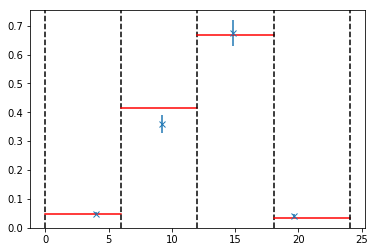

In [36]:
i=randint(nsims_train)
k1,x1,e1,c1=equal_spacing_ps(x_train[i],(size/2+1)*2**.5/nbands)
errorbar(k1,x1,yerr=e1,marker="x",ls="")
for j in range(4):
    axvline(x=j*(size/2+1)*2**.5/nbands,c="k",ls="--")
    plot(array([j,j+1])*(size/2+1)*2**.5/nbands,repeat(p_train[i,j],2),c="r")
axvline(x=(size/2+1)*2**.5,c="k",ls="--")
c1

In [37]:
model = PSEp_2d_32_4b(['x'], ['p'], model_dir='/global/cscratch1/sd/avirukt/models/pse2_4b_model5')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/global/cscratch1/sd/avirukt/models/pse2_4b_model5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aad1917b9e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [38]:
model.train(_training_fn,max_steps=40000)

INFO:tensorflow:Skipping training since max_steps has already saved.


In [39]:
pred = model.predict(_testing_fn)
cnn_pred=zeros((2,nsims_test,nbands))
for i in range(nsims_test):
    cnn_pred[0,i]=(next(pred)[0]+1)/2
    cnn_pred[1,i]=equal_spacing_ps(x_test[i],(size/2+1)*2**.5/nbands)[1]
print(mean((cnn_pred[0]-p_test)**2),mean((cnn_pred[1]-p_test)**2))
mu=mean(cnn_pred[0]-p_test,axis=0)
sig=std(cnn_pred[0]-p_test,axis=0)
print(mu,sig**2)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/pse2_4b_model5/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.12229756442818476 0.008981633561592168
[-0.01363195 -0.02160141 -0.01528031  0.00129307] [0.01817583 0.15449706 0.16013096 0.15549881]


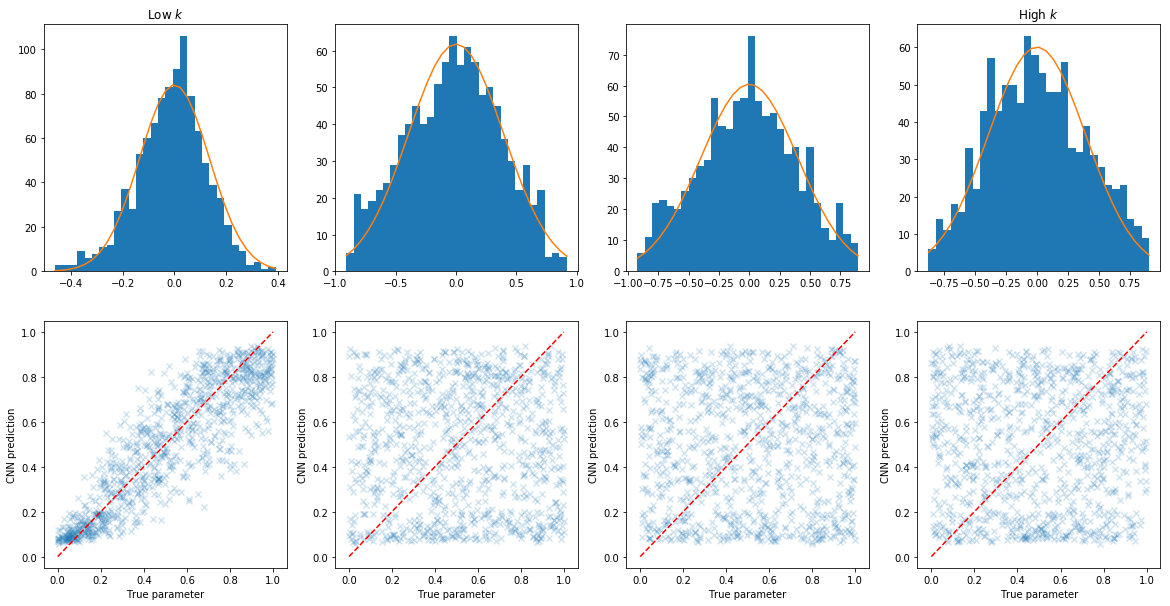

In [40]:
figure(figsize=(20,10))
for i in range(nbands):
    subplot(241+i)
    if i==0:
        title("Low $k$")
    if i==nbands-1:
        title("High $k$")
    count,edges,patches=hist((cnn_pred[0,:,i]-p_test[:,i]).flatten(),bins=30)
    plot(edges,gauss(edges,sig[i],nsims_test))
    subplot(245+i)
    plot(linspace(0,1,100),linspace(0,1,100),c="r",ls="--")
    scatter(p_test[:,i],cnn_pred[0,:,i],alpha=0.2,marker="x")
    xlabel("True parameter")
    ylabel("CNN prediction")

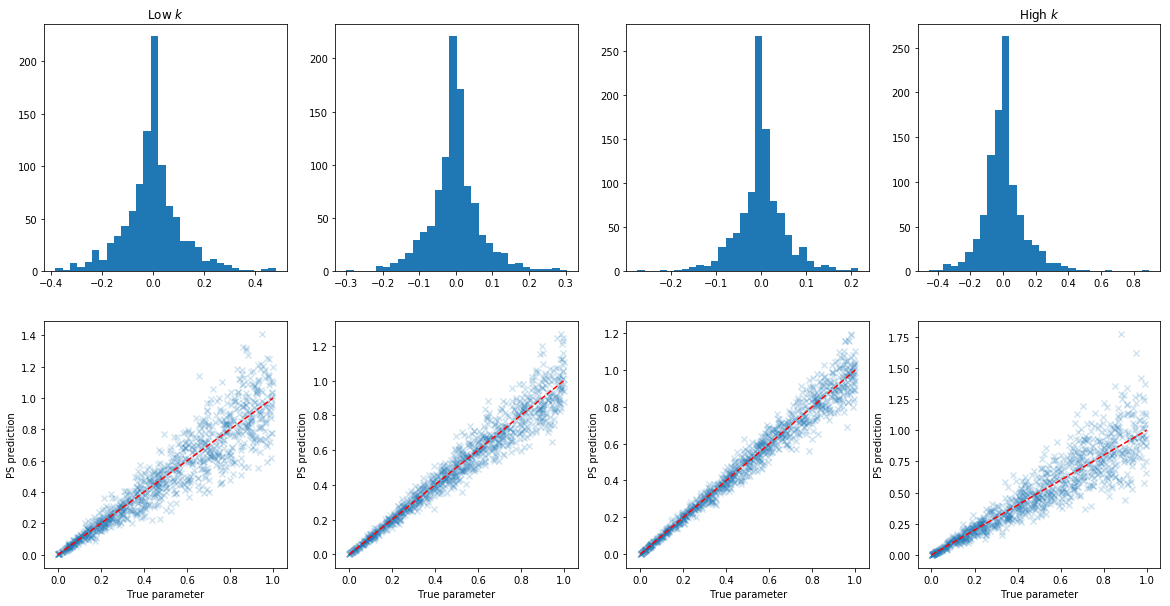

In [41]:
figure(figsize=(20,10))
for i in range(nbands):
    subplot(241+i)
    if i==0:
        title("Low $k$")
    if i==nbands-1:
        title("High $k$")
    count,edges,patches=hist((cnn_pred[1,:,i]-p_test[:,i]).flatten(),bins=30)
    subplot(245+i)
    plot(linspace(0,1,100),linspace(0,1,100),c="r",ls="--")
    scatter(p_test[:,i],cnn_pred[1,:,i],alpha=0.2,marker="x")
    xlabel("True parameter")
    ylabel("PS prediction")

To compare errors fairly, let's space bands so that they have equal counts of pixels rather than the naive equal spacing.

In [42]:
k,f=get_flt_k_f(x_train[randint(nsims_train)])
ind,e=bin_by_count(k,size**2/nbands)
i=0
while len(ind)<nbands:
    i+=1
    ind,e=bin_by_count(k,size**2/nbands-i)
critks=[0.5*(k[ind[j][-1]]+k[ind[j+1][0]]) for j in range(nbands-1)]
critks=array([0]+critks+[(size/2+1)*2**.5])
print(i,critks,[len(i) for i in ind])

3 [ 0.          9.02769257 12.76708527 15.6364876  24.04163056] [253, 256, 260, 255]


In [43]:
# Parametrise ps
def pps(par):
    return lambda k: par[where(critks>=k)[0][0]-1]

[0.44856474 0.4888724  0.33962076 0.29585619]


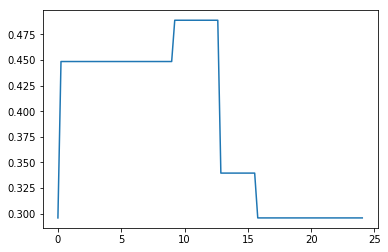

In [44]:
f=pps(p_train[i])
print(p_train[i])
a=linspace(critks[0],critks[-1],100)
plot(a,[f(aa) for aa in a])

In [45]:
x_train = array([field_from_spectrum(pps(p),boxsize=size)[0] for p in p_train])
x_test = array([field_from_spectrum(pps(p),boxsize=size)[0] for p in p_test])

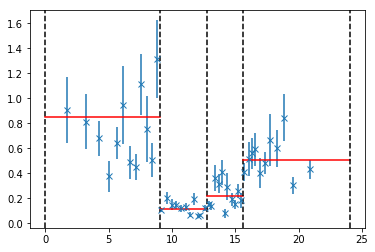

In [46]:
i=randint(nsims_train)
k1,x1,e1,c1=dynamic_ps(x_train[i])
errorbar(k1,x1,yerr=e1,marker="x",ls="")
for j in range(4):
    axvline(x=critks[j],c="k",ls="--")
    plot(critks[j:j+2],repeat(p_train[i,j],2),c="r")
axvline(x=critks[-1],c="k",ls="--")

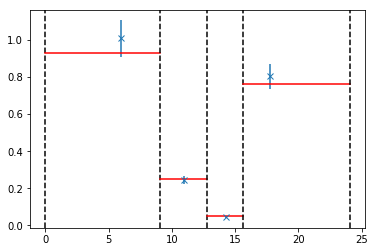

In [47]:
i=randint(nsims_train)
k1,x1,e1,c1=dynamic_ps(x_train[i],253)
errorbar(k1,x1,yerr=e1,marker="x",ls="")
for j in range(4):
    axvline(x=critks[j],c="k",ls="--")
    plot(critks[j:j+2],repeat(p_train[i,j],2),c="r")
axvline(x=critks[-1],c="k",ls="--")

array([0.5792687 , 0.01371786, 0.87967172, 0.74193412])

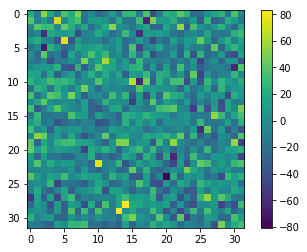

In [48]:
i=randint(nsims_train)
imshow(x_train[i])
colorbar()
p_train[i]

In [49]:
model = PSEp_2d_32_4b(['x'], ['p'], model_dir='/global/cscratch1/sd/avirukt/models/pse2_4b_model1')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/global/cscratch1/sd/avirukt/models/pse2_4b_model1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aad1bfaa470>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [50]:
model.train(_training_fn,max_steps=40000)

INFO:tensorflow:Skipping training since max_steps has already saved.


In [51]:
pred = model.predict(_testing_fn)
cnn_pred=zeros((2,nsims_test,nbands))
for i in range(nsims_test):
    cnn_pred[0,i]=(next(pred)[0]+1)/2
    cnn_pred[1,i]=dynamic_ps(x_test[i],count=253)[1]
print(mean((cnn_pred[0]-p_test)**2),mean((cnn_pred[1]-p_test)**2))
mu=mean(cnn_pred[0]-p_test,axis=0)
sig=std(cnn_pred[0]-p_test,axis=0)
print(mu,sig**2)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/pse2_4b_model1/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.11977592710528745 0.004978131478800947
[ 0.00703748 -0.00093198  0.00538911  0.0219625 ] [0.01983144 0.14480322 0.16315337 0.1507539 ]


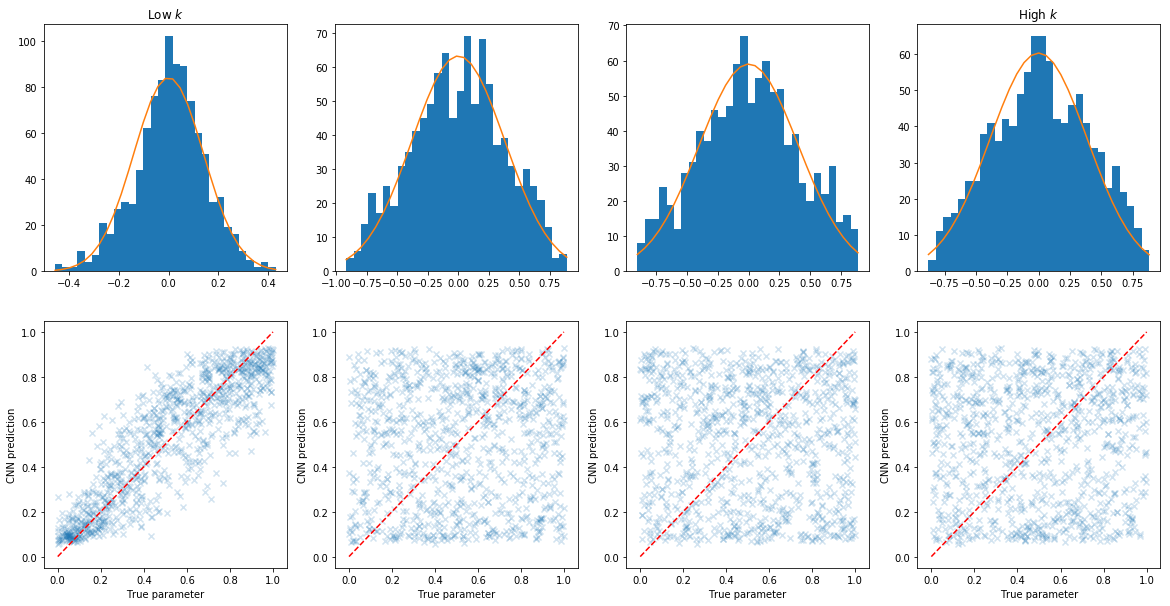

In [52]:
figure(figsize=(20,10))
for i in range(nbands):
    subplot(241+i)
    if i==0:
        title("Low $k$")
    if i==nbands-1:
        title("High $k$")
    count,edges,patches=hist((cnn_pred[0,:,i]-p_test[:,i]).flatten(),bins=30)
    plot(edges,gauss(edges,sig[i],nsims_test))
    subplot(245+i)
    plot(linspace(0,1,100),linspace(0,1,100),c="r",ls="--")
    scatter(p_test[:,i],cnn_pred[0,:,i],alpha=0.2,marker="x")
    xlabel("True parameter")
    ylabel("CNN prediction")

Machine is learning large scale information, but not well. Not learning other bands at all. Why doesn't it learn to always predict 0.5? That has lower error than the training error (which is lower than the testing error, so it is overfitting).

Below is standard power spectrum result for same problem. It's much better.

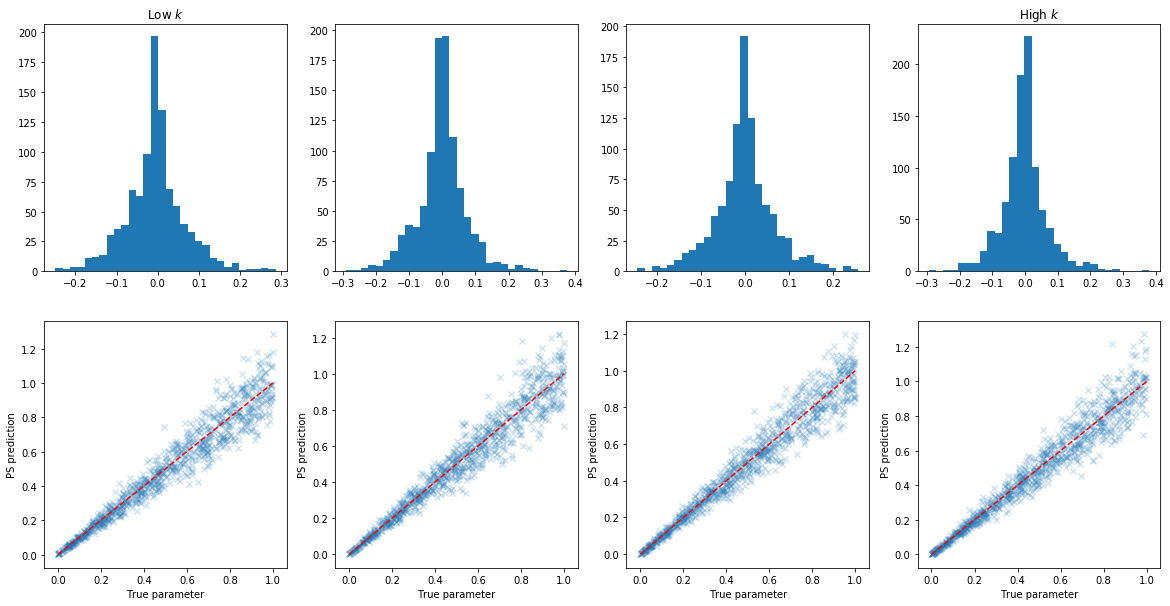

In [53]:
figure(figsize=(20,10))
for i in range(nbands):
    subplot(241+i)
    if i==0:
        title("Low $k$")
    if i==nbands-1:
        title("High $k$")
    count,edges,patches=hist((cnn_pred[1,:,i]-p_test[:,i]).flatten(),bins=30)
    subplot(245+i)
    plot(linspace(0,1,100),linspace(0,1,100),c="r",ls="--")
    scatter(p_test[:,i],cnn_pred[1,:,i],alpha=0.2,marker="x")
    xlabel("True parameter")
    ylabel("PS prediction")

Just for reference, here is what it would look like if the CNN gave a random output. It is very similar.

0.16650914772536846
[-0.00809901 -0.01301082 -0.0023557   0.00245527] [0.1655482  0.1584065  0.17193626 0.16989918]


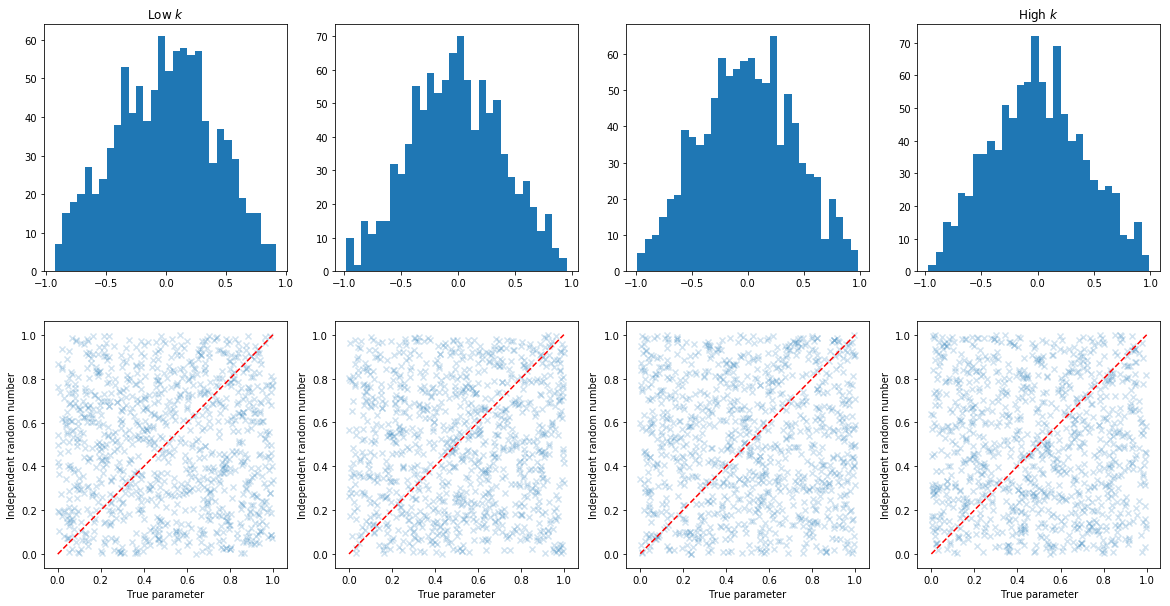

In [54]:
cnn_pred=rand(nsims_test,nbands)
print(mean((cnn_pred-p_test)**2))
mu=mean(cnn_pred-p_test,axis=0)
sig=std(cnn_pred-p_test,axis=0)
print(mu,sig**2)
figure(figsize=(20,10))
for i in range(nbands):
    subplot(241+i)
    if i==0:
        title("Low $k$")
    if i==nbands-1:
        title("High $k$")
    count,edges,patches=hist((cnn_pred[:,i]-p_test[:,i]).flatten(),bins=30)
    subplot(245+i)
    plot(linspace(0,1,100),linspace(0,1,100),c="r",ls="--")
    scatter(p_test[:,i],cnn_pred[:,i],alpha=0.2,marker="x")
    xlabel("True parameter")
    ylabel("Independent random number")

Trying the same thing with mean pooling instead of max pooling and with fewer tanh layers. (The original 1-parameter PS model had 5-6 tanh layers, I changed most of them to leaky ReLUs.)

In [55]:
import tensorflow as tf

class PSEp_2d_32_4b_v2(tf.estimator.Estimator):

    def __init__(self,
               feature_columns,
               label_columns,
               optimizer=tf.train.AdamOptimizer,
               activation_fn=tf.nn.relu,
               normalizer_fn=tf.contrib.layers.batch_norm,
               dropout=None,
               model_dir=None,
               config=None):

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,32,32,1)), 4, 3, activation=tf.nn.leaky_relu)
            pool = tf.layers.average_pooling2d(conv, 3,2)
            conv = tf.layers.conv2d(pool, 16, 3, activation=tf.nn.leaky_relu)
            pool = tf.layers.average_pooling2d(conv, 3,2)
            conv = tf.layers.conv2d(pool, 64, 3, activation=tf.nn.leaky_relu)
            pool = tf.reshape(tf.layers.average_pooling2d(conv, 3,2),(-1,64))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(pool,rate=0.2,training=training),32,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),16,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),8,activation_fn=tf.nn.tanh)
            predictions = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),4,activation_fn=tf.nn.tanh)

            train_op = None
            eval_metric_ops = None
            
            # Define optimizer
            if mode == tf.estimator.ModeKeys.PREDICT:
                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
            
            loss=tf.losses.mean_squared_error(predictions,labels)
            
            if training:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.0002).minimize(loss=loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "loss": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)

In [56]:
model = PSEp_2d_32_4b_v2(['x'], ['p'], model_dir='/global/cscratch1/sd/avirukt/models/pse2_4b_model4')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/global/cscratch1/sd/avirukt/models/pse2_4b_model4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aadc4aa4400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [57]:
model.train(_training_fn,max_steps=50000)

INFO:tensorflow:Skipping training since max_steps has already saved.


In [58]:
pred = model.predict(_testing_fn)
cnn_pred=zeros((nsims_test,nbands))
for i in range(nsims_test):
    cnn_pred[i]=(next(pred)[0]+1)/2
print(mean((cnn_pred-p_test)**2))
mu=mean(cnn_pred-p_test,axis=0)
sig=std(cnn_pred-p_test,axis=0)
print(mu,sig**2)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/pse2_4b_model4/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.12446952594260942
[-0.02314486 -0.03111432 -0.02479322 -0.00821984] [0.0071634  0.15936713 0.16862749 0.16053403]


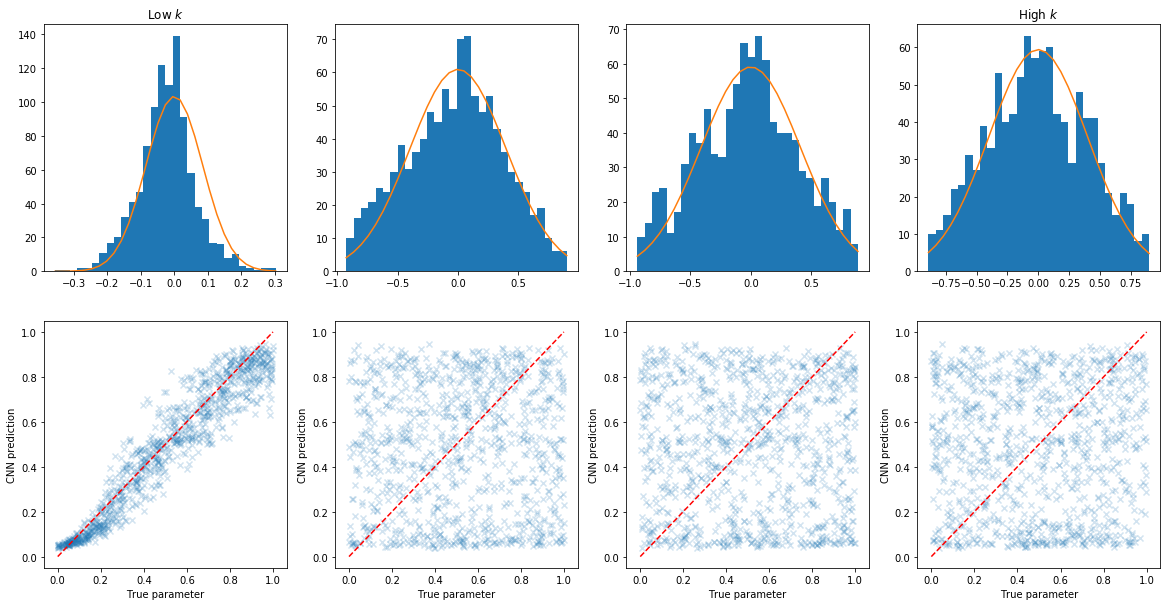

In [59]:
figure(figsize=(20,10))
for i in range(nbands):
    subplot(241+i)
    if i==0:
        title("Low $k$")
    if i==nbands-1:
        title("High $k$")
    count,edges,patches=hist((cnn_pred[:,i]-p_test[:,i]).flatten(),bins=30)
    plot(edges,gauss(edges,sig[i],nsims_test))
    subplot(245+i)
    plot(linspace(0,1,100),linspace(0,1,100),c="r",ls="--")
    scatter(p_test[:,i],cnn_pred[:,i],alpha=0.2,marker="x")
    xlabel("True parameter")
    ylabel("CNN prediction")

Doesn't work. Let's try adding some more dense layers.

In [60]:
import tensorflow as tf

class PSEp_2d_32_4b_v3(tf.estimator.Estimator):

    def __init__(self,
               feature_columns,
               label_columns,
               optimizer=tf.train.AdamOptimizer,
               activation_fn=tf.nn.relu,
               normalizer_fn=tf.contrib.layers.batch_norm,
               dropout=None,
               model_dir=None,
               config=None):

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,32,32,1)), 4, 3, activation=tf.nn.leaky_relu)
            pool = tf.layers.max_pooling2d(conv, 3,2)
            conv = tf.layers.conv2d(pool, 16, 3, activation=tf.nn.leaky_relu)
            pool = tf.layers.max_pooling2d(conv, 3,2)
            conv = tf.layers.conv2d(pool, 64, 3, activation=tf.nn.leaky_relu)
            pool = tf.reshape(tf.layers.max_pooling2d(conv, 3,2),(-1,64))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(pool,rate=0.2,training=training),128,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),256,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),64,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),16,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),8,activation_fn=tf.nn.tanh)
            predictions = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),4,activation_fn=tf.nn.tanh)

            train_op = None
            eval_metric_ops = None
            
            # Define optimizer
            if mode == tf.estimator.ModeKeys.PREDICT:
                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
            
            loss=tf.losses.mean_squared_error(predictions,labels)
            
            if training:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.0002).minimize(loss=loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "loss": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)

In [61]:
model = PSEp_2d_32_4b_v3(['x'], ['p'], model_dir='/global/cscratch1/sd/avirukt/models/pse2_4b_model6')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/global/cscratch1/sd/avirukt/models/pse2_4b_model6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aad1bf7f6a0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [62]:
model.train(_training_fn,max_steps=40000)

INFO:tensorflow:Skipping training since max_steps has already saved.


In [63]:
pred = model.predict(_testing_fn)
cnn_pred=zeros((nsims_test,nbands))
for i in range(nsims_test):
    cnn_pred[i]=(next(pred)[0]+1)/2
print(mean((cnn_pred-p_test)**2))
mu=mean(cnn_pred-p_test,axis=0)
sig=std(cnn_pred-p_test,axis=0)
print(mu,sig**2)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/pse2_4b_model6/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.11834859798189014
[-0.02876473 -0.03673419 -0.0304131  -0.01383971] [0.01488574 0.14808181 0.16025941 0.14687413]


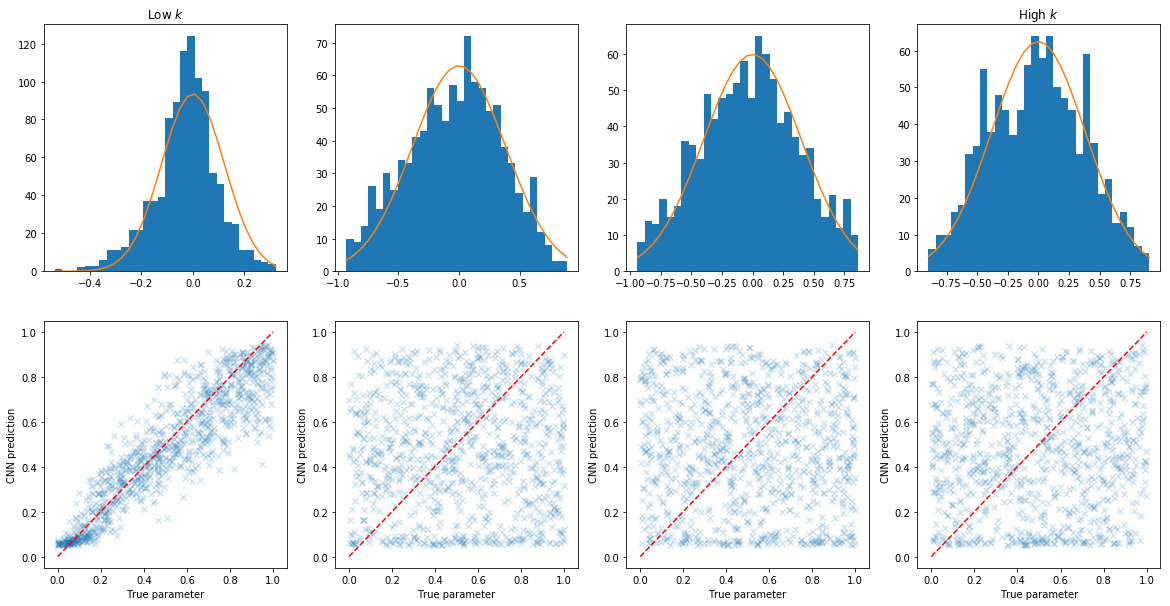

In [64]:
figure(figsize=(20,10))
for i in range(nbands):
    subplot(241+i)
    if i==0:
        title("Low $k$")
    if i==nbands-1:
        title("High $k$")
    count,edges,patches=hist((cnn_pred[:,i]-p_test[:,i]).flatten(),bins=30)
    plot(edges,gauss(edges,sig[i],nsims_test))
    subplot(245+i)
    plot(linspace(0,1,100),linspace(0,1,100),c="r",ls="--")
    scatter(p_test[:,i],cnn_pred[:,i],alpha=0.2,marker="x")
    xlabel("True parameter")
    ylabel("CNN prediction")

Still not working. Let's try using convolutions with strides, in case the pooling layers are losing small-scale info..?

In [65]:
class PSEp_2d_32_4b_v4(tf.estimator.Estimator):

    def __init__(self,
               feature_columns,
               label_columns,
               optimizer=tf.train.AdamOptimizer,
               activation_fn=tf.nn.relu,
               normalizer_fn=tf.contrib.layers.batch_norm,
               dropout=None,
               model_dir=None,
               config=None):

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,32,32,1)), 2, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 4, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 8, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 16, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.reshape(tf.layers.conv2d(conv, 32, 2, strides=2, activation=tf.nn.leaky_relu),(-1,32))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(conv,rate=0.2,training=training),64,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),32,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),16,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),8,activation_fn=tf.nn.tanh)
            predictions = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),4,activation_fn=tf.nn.tanh)

            train_op = None
            eval_metric_ops = None
            
            # Define optimizer
            if mode == tf.estimator.ModeKeys.PREDICT:
                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
            
            loss=tf.losses.mean_squared_error(predictions,labels)
            
            if training:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.0002).minimize(loss=loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "loss": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)

In [66]:
model = PSEp_2d_32_4b_v4(['x'], ['p'], model_dir='/global/cscratch1/sd/avirukt/models/pse2_4b_model7')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/global/cscratch1/sd/avirukt/models/pse2_4b_model7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aad1bbd6a58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [67]:
model.train(_training_fn,max_steps=80000)

INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/pse2_4b_model7/model.ckpt-80000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.10719924840995793
[-0.00447123 -0.01244069 -0.0061196   0.01045379] [0.01600247 0.11197344 0.1426646  0.157835  ]


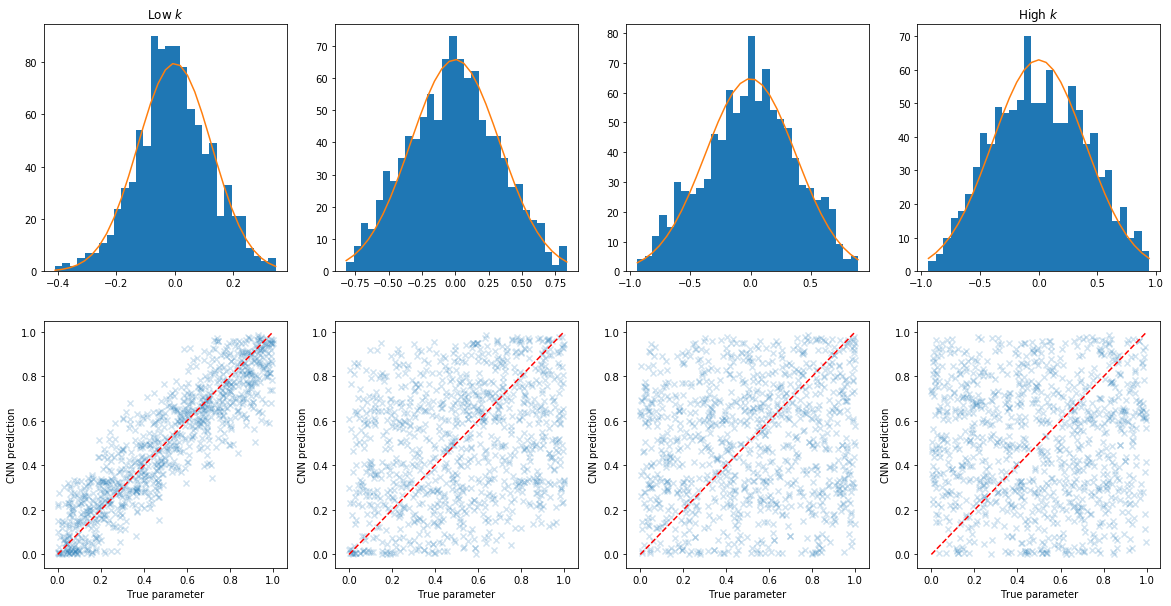

In [68]:
pred = model.predict(_testing_fn)
cnn_pred=zeros((nsims_test,nbands))
for i in range(nsims_test):
    cnn_pred[i]=(next(pred)[0]+1)/2
print(mean((cnn_pred-p_test)**2))
mu=mean(cnn_pred-p_test,axis=0)
sig=std(cnn_pred-p_test,axis=0)
print(mu,sig**2)
figure(figsize=(20,10))
for i in range(nbands):
    subplot(241+i)
    if i==0:
        title("Low $k$")
    if i==nbands-1:
        title("High $k$")
    count,edges,patches=hist((cnn_pred[:,i]-p_test[:,i]).flatten(),bins=30)
    plot(edges,gauss(edges,sig[i],nsims_test))
    subplot(245+i)
    plot(linspace(0,1,100),linspace(0,1,100),c="r",ls="--")
    scatter(p_test[:,i],cnn_pred[:,i],alpha=0.2,marker="x")
    xlabel("True parameter")
    ylabel("CNN prediction")

In [103]:
tf.trainable_variables()

[<tf.Variable 'conv2d/kernel:0' shape=(2, 2, 1, 2) dtype=float32_ref>,
 <tf.Variable 'conv2d/bias:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/kernel:0' shape=(2, 2, 2, 4) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/bias:0' shape=(4,) dtype=float32_ref>,
 <tf.Variable 'conv2d_2/kernel:0' shape=(2, 2, 4, 8) dtype=float32_ref>,
 <tf.Variable 'conv2d_2/bias:0' shape=(8,) dtype=float32_ref>,
 <tf.Variable 'conv2d_3/kernel:0' shape=(2, 2, 8, 16) dtype=float32_ref>,
 <tf.Variable 'conv2d_3/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'conv2d_4/kernel:0' shape=(2, 2, 16, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d_4/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'fully_connected/weights:0' shape=(32, 64) dtype=float32_ref>,
 <tf.Variable 'fully_connected/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'fully_connected_1/weights:0' shape=(64, 32) dtype=float32_ref>,
 <tf.Variable 'fully_connected_1/biases:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable '

In [4]:
#sess=tf.Session()
tf.get_default_session()
#sess.run(tf.global_variables_initializer())
#tf.trainable_variables()[0].value().eval(session=sess)

NameError: name 'tf' is not defined

In [110]:
sess.run(tf.trainable_variables()[0])

ValueError: Fetch argument <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 1, 4) dtype=float32_ref> cannot be interpreted as a Tensor. (Tensor Tensor("conv2d/kernel:0", shape=(3, 3, 1, 4), dtype=float32_ref) is not an element of this graph.)

In [81]:
tf.get_default_graph().get_tensor_by_name('conv2d/kernel:0').eval()

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [98]:
class PSEp_2d_open(tf.estimator.Estimator):

    def __init__(self,
               feature_columns,
               label_columns,
               optimizer=tf.train.AdamOptimizer,
               activation_fn=tf.nn.relu,
               normalizer_fn=tf.contrib.layers.batch_norm,
               dropout=None,
               model_dir=None,
               config=None):
        """Initializes a PSE_1d_v1 instance.
        """

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,32,32,1)), 4, 3, activation=tf.nn.leaky_relu)
            pool = tf.layers.max_pooling2d(conv, 3,2)
            conv = tf.layers.conv2d(pool, 16, 3, activation=tf.nn.leaky_relu)
            pool = tf.layers.max_pooling2d(conv, 3,2)
            conv = tf.layers.conv2d(pool, 64, 3, activation=tf.nn.leaky_relu)
            pool = tf.reshape(tf.layers.max_pooling2d(conv, 3,2),(-1,64))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(pool,rate=0.2,training=training),32,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),16,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),8,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),4,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),2,activation_fn=tf.nn.tanh)
            predictions = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),1,activation_fn=tf.nn.tanh)

            train_op = None
            eval_metric_ops = None
            
            # Define optimizer
            if mode == tf.estimator.ModeKeys.PREDICT:
                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
            
            loss=tf.losses.mean_squared_error(predictions,labels)
            
            if training:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.0002).minimize(loss=loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                d={}
                for tv in tf.trainable_variables():
                    d[tv.name] = tv.value().eval(session=tf.Session())
                eval_metric_ops = { "loss": loss, "weights": d}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)

In [99]:
model = PSEp_2d_open(['x'], ['p'], model_dir='models/pse2_model2')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/pse2_model2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aad1b5f5f60>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [19]:
# box size
size=32

# Define input function for estimator
batch_size = 1024
fNL=1

nsims_test = 1000

# Parametrise ps
def pps(par):
    return lambda x: (x+.5)**-par

p_test = 5*rand(nsims_test,1)

x_test = array([renorm_count(add_nl_proper(field_from_spectrum(pps(p[0]),boxsize=size)[0],fNL,pps(p[0])),pps(p[0])) for p in p_test])

normalised_p_test = (p_test-2.5)/2.5

def _testing_input_fn():
    """Serving input fn for testing data"""
    dataset = tf.data.Dataset.from_tensor_slices((x_test.astype('float32'), normalised_p_test.astype('float32')))
    dataset = dataset.batch(batch_size)
    return dataset

In [107]:
dummy_fn=lambda: tf.data.Dataset.from_tensor_slices((field_from_spectrum(lambda x: 1,boxsize=32).astype('float32'), (2*rand(1,1,1)-1).astype('float32')))
a=model.predict(dummy_fn)

In [108]:
next(a)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/pse2_model2/model.ckpt-30040
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


array([-0.96776974], dtype=float32)

In [97]:
field_from_spectrum(lambda x:1,boxsize=32,n=5).shape

(5, 32, 32)

In [85]:
g= lambda: 5

In [86]:
g()

5

In [111]:
tf.saved_model.loader.load(sess,["train"],'models/pse2_model2')

OSError: SavedModel file does not exist at: models/pse2_model2/{saved_model.pbtxt|saved_model.pb}